In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload # reloads modules
# %aimport # lists what it will/won't reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split

from utils import *

### Test multiple classification methods with the original data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Clearly feature engineering isn't really an option here since we are dealing with SVD modes.


| Columns       | Description |
|:------------- |:-------------|
| amount        | amount of transaction in cents|
| time          | time of transaction in seconds|
| class         | boolean fraudulent/legitimate-->1/0|
| V\*           | SVD features (US in svd USV')|

In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

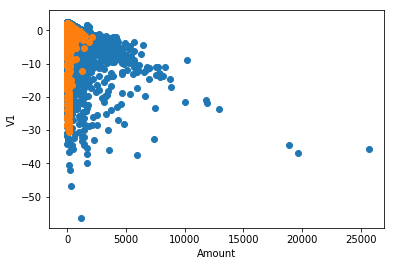

In [4]:
ax = plot_features('Amount','V1',data)
plt.show()

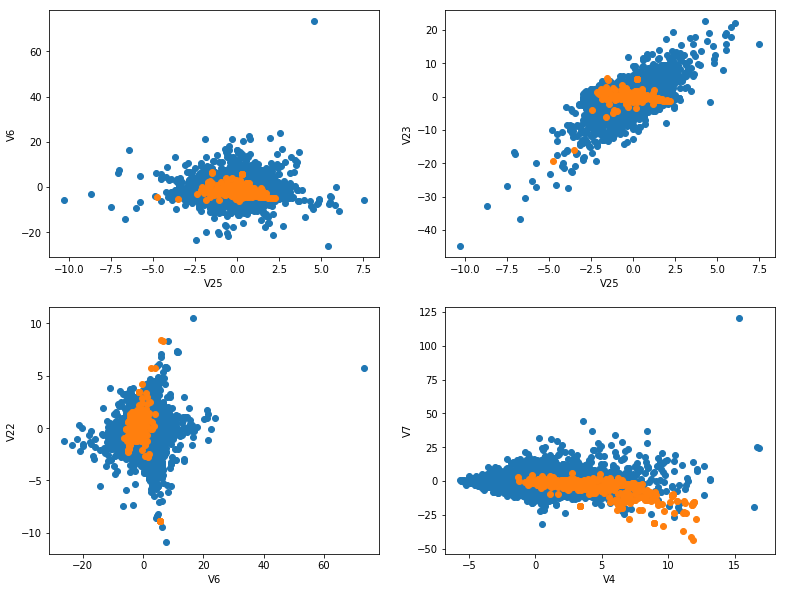

In [5]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)
# list(np.random.choice(col_names, 2, replace=False)) + ['squat']

Data often doesn't look very Gaussian does it... We would expect those appraoches to be bad. We could try to restrict outselves to set of features that do look roughly gaussian.. but since that's prolly hard it's prolly best to simply use it naively and accept that it won't work very well.

KNN looks like a much more promising approach, granted we alter the cost function to predict the minority class when there are verrry few within the nearest k (maybe 1..). This sounds like a recipe for overfitting however. Perhaps to match this with SMOTE would make for good results.

SVM, or really any linear classifier, looks like it would perform poorly.

#### Prep data

In [6]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00170291206741
0.00182577858923


In [7]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_class(train)]
test_x, test_y = [df.as_matrix() for df in split_class(test)]
X, y = [df.as_matrix() for df in split_class(data)]

### Implement classification methods

Find the best classifiers for this dataset. Here is where we test any potential algorithm improvements to the class imbalance.

#### Gaussian Methods
It seems pretty absurd to use LDA here given that each class must share the same covariance matrix. Based on above plots this seems silly, and basically completely determined by the majority class. Let's try quadratic discriminant analysis instead, plus Naive Bayes. Naive Bayes is like QDA with diagonal covariance matrices, so more restricted

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

print "QDA"
qda = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
print_metrics(test_y, qda.predict(test_x))
print_avg_recall(qda,X,y)

print ''
print "Naive Bayes"
nb = GaussianNB().fit(train_x, train_y)
print_metrics(test_y, nb.predict(test_x))
print_avg_recall(nb,X,y)

QDA
Geometric mean:	0.897156308105
Recall: 	0.826923076923
Precision:	0.053716427233
Accuracy:	0.973087321372
Confusion mat: 
[[55343  1515]
 [   18    86]]
Mean recall score (QuadraticDiscriminantAnalysis): 0.87

Naive Bayes
Geometric mean:	0.763314736529
Recall: 	0.586538461538
Precision:	0.139269406393
Accuracy:	0.99262666339
Confusion mat: 
[[56481   377]
 [   43    61]]
Mean recall score (GaussianNB): 0.66


Surprisingly QDA actually did pretty well.

#### Decision Tree
Scikit docs:
>Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(train_x, train_y)
print_metrics(test_y, tree.predict(test_x))
print_avg_recall(tree,X,y)

Geometric mean:	0.78431965965
Recall: 	0.615384615385
Precision:	0.752941176471
Accuracy:	0.998929110635
Confusion mat: 
[[56837    21]
 [   40    64]]
Mean recall score (DecisionTreeClassifier): 0.73


#### KNN

Scikit didn't allow me to tune the built in classifier in the way I wanted so I made my own, built on scikit's NearestNeighbors algorithms. Essentially instead of each of the N neighbors getting a equal vote for which class the test point should be, I wanted the minorty class to have a more impactful vote. In the most extreme case this means that if _any_ of the neighbors are members of the minority class then we assign the minority class to the test point as well.

Note: KNN is known to not perform well on high dimensional data

In [10]:
from WeightedKNN import WeightedKNN

N = 9

weight = 1 # weight 1 means majority vote
print "Boring majority vote condition"
wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
print_metrics(test_y, wknn.predict(test_x))
# print_avg_recall(wknn,X,y,'')

weight = 3
print "Unequal voting: class 1 gets {} votes".format(weight)
wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
print_metrics(test_y, wknn.predict(test_x))
# print_avg_recall(wknn,X,y,'')

weight = N # for all weight values > (N+1)/2 you get the one vote counts case
print "Vigilant condition: is fraud if _any_ neightbors are"
wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
print_metrics(test_y, wknn.predict(test_x))
# print_avg_recall(wknn,X,y,'')

Boring majority vote condition
Geometric mean:	0.138675049056
Recall: 	0.0192307692308
Precision:	1.0
Accuracy:	0.998209332537
Confusion mat: 
[[56858     0]
 [  102     2]]
Unequal voting: class 1 gets 3 votes
Geometric mean:	0.353516079533
Recall: 	0.125
Precision:	0.52
Accuracy:	0.998191776974
Confusion mat: 
[[56846    12]
 [   91    13]]
Vigilant condition: is fraud if _any_ neightbors are
Geometric mean:	0.498419006669
Recall: 	0.25
Precision:	0.0675324675325
Accuracy:	0.992328218813
Confusion mat: 
[[56499   359]
 [   78    26]]


Conclusion: Even in the 'vigilant' case this method doesn't do a great job on recall.

#### Logistic Regression

You can also add a L1 or L2 regularization term. We don't have any reason to think that promoting sparisity on the input would be helpful here but we will test it anyway.

In [11]:
# Vanilla version
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(class_weight='balanced') # class_weight is very important
logit.fit(train_x, train_y)

pred = logit.predict(test_x)
print_metrics(test_y, pred)

Geometric mean:	0.931472624032
Recall: 	0.884615384615
Precision:	0.0777683854607
Accuracy:	0.980636213616
Confusion mat: 
[[55767  1091]
 [   12    92]]


Hey, pretty damn good! But let's use GridSearch to find the best combination of hyperparameters

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'penalty':['l1','l2'], 'C': [1.0/1000, 1.0/100, 1./10, 1, 10], 'class_weight': ['balanced']}
 ]
gs = GridSearchCV(LogisticRegression(), param_grid, scoring='recall')
gs.fit(train_x, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': ['balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [13]:
print 'Recall Scores'
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
print ''
print "Best parameters"
print gs.best_params_
print ''

print_metrics(test_y, gs.predict(test_x))

Recall Scores
0.907 (+/-0.001) for {'penalty': 'l1', 'C': 0.001, 'class_weight': 'balanced'}
0.912 (+/-0.007) for {'penalty': 'l2', 'C': 0.001, 'class_weight': 'balanced'}
0.910 (+/-0.014) for {'penalty': 'l1', 'C': 0.01, 'class_weight': 'balanced'}
0.910 (+/-0.014) for {'penalty': 'l2', 'C': 0.01, 'class_weight': 'balanced'}
0.910 (+/-0.007) for {'penalty': 'l1', 'C': 0.1, 'class_weight': 'balanced'}
0.910 (+/-0.007) for {'penalty': 'l2', 'C': 0.1, 'class_weight': 'balanced'}
0.910 (+/-0.007) for {'penalty': 'l1', 'C': 1, 'class_weight': 'balanced'}
0.910 (+/-0.007) for {'penalty': 'l2', 'C': 1, 'class_weight': 'balanced'}
0.910 (+/-0.007) for {'penalty': 'l1', 'C': 10, 'class_weight': 'balanced'}
0.910 (+/-0.007) for {'penalty': 'l2', 'C': 10, 'class_weight': 'balanced'}

Best parameters
{'penalty': 'l2', 'C': 0.001, 'class_weight': 'balanced'}

Geometric mean:	0.94604550114
Recall: 	0.913461538462
Precision:	0.0763665594855
Accuracy:	0.979670657631
Confusion mat: 
[[55709  1149]
 [ 

Not much different than the non-regularized version... so still good

#### The best 3 methods appear to be Logistic Regression and QDA, with Decision Trees being a little behind. KNN was poor.

### ROC and PR curves

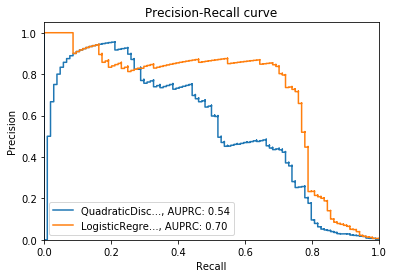

In [14]:
plt.figure()
ax = plt.subplot(111)

plot_pr(qda, test_x, test_y, ax=ax)
# plot_pr(tree, test_x, test_y, ax=ax)
plot_pr(logit, test_x, test_y, ax=ax)
plt.show()

This isn't very useful because we don't really care much about the precision of class 1 classification. A low precision is acceptable. We really want our true negative rate (tn/fp+tn) or our accurancy (which is close to TN rate) to stay high. Potentially useful to compare methods however

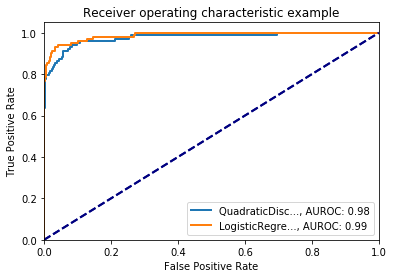

In [15]:
plt.figure()
ax = plt.subplot(111)

plot_roc(qda, test_x, test_y, ax=ax)
plot_roc(logit, test_x, test_y, ax=ax)
plt.show()

ROC/AUROC may also not be very helpful in this situation, since it tends to assume you want to reduce false classifications equally. Of course we still want to maximize the true positive rate (TPR) and minimize the false positive rate (FPR), so it might help you decide between methods.